<a href="https://colab.research.google.com/gist/amoux/206bd69f2f9cb6d544ddf05947f2b08e/solving-fizzbuzz-with-simple-net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm.auto import tqdm
from collections import namedtuple
import numpy as np
import nltk

import ego
import ego.nn as nn
import ego.nn.functional as F
import ego.data.fizzbuzz as fizzbuzz

In [ ]:
Batch = namedtuple('Batch', ['inputs', 'target'])

def collator_wrapper(batch) -> Batch:
    inputs, target = map(ego.stack, zip(*batch))
    return Batch(inputs, target)


x_train, y_train = fizzbuzz.load_data(101, 1023)
y_train = y_train.squeeze()

dataset = ego.utils.data.TensorDataset(x_train, y_train)
dataloader = ego.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=True, collate_fn=collator_wrapper)

In [ ]:
in_features = 10
out_features = 4
hidden_size = 50

model = nn.Sequential(
    nn.Linear(in_features, hidden_size),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, out_features),
)
model.apply(fizzbuzz.init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = ego.optim.Adam(model.parameters(), lr=0.01)

print(f"number of parameters: {model.num_parameters():,}")

number of parameters: 3,304


In [ ]:
steps = 200
grad_max_norm = 0.5
grad_accumulation_steps = 2
epochs = tqdm(range(1, steps + 1), leave=False)
for epoch in epochs:
    optimizer.zero_grad(set_to_none=True)
    total, total_loss, total_acc = 0, 0, 0
    for step, (inputs, targets) in enumerate(dataloader):
        output = model(inputs)
        loss = criterion(output, targets)
        (loss / grad_accumulation_steps).backward()
        loss.detach_()
        output.detach_()
        nn.utils.clip_grad_norm_(model.parameters(), grad_max_norm)
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        n_pred = (output.argmax(-1) == targets.view(-1)).sum().item()
        N = targets.size(0)
        loss = loss.item()
        epochs.set_description(
            f'[{epoch}/{steps}] loss: {loss:.3f} acc: {100*n_pred/N:.1f}% ')
        total += N
        total_loss += loss
        total_acc += n_pred
    if epoch % 20 == 0:
        avg_loss, avg_acc = (total_loss / total), (100*(total_acc/total))
        print(f"\t[epoch: {epoch}]\tavg-loss: {avg_loss:.5f}\tavg-acc: {avg_acc:.1f} %")

  0%|          | 0/200 [00:00<?, ?it/s]

	[epoch: 20]	avg-loss: 0.00807	avg-acc: 85.5 %
	[epoch: 40]	avg-loss: 0.00165	avg-acc: 98.8 %
	[epoch: 60]	avg-loss: 0.00071	avg-acc: 99.3 %
	[epoch: 80]	avg-loss: 0.00044	avg-acc: 99.8 %
	[epoch: 100]	avg-loss: 0.00031	avg-acc: 99.8 %
	[epoch: 120]	avg-loss: 0.00022	avg-acc: 99.9 %
	[epoch: 140]	avg-loss: 0.00019	avg-acc: 99.9 %
	[epoch: 160]	avg-loss: 0.00014	avg-acc: 100.0 %
	[epoch: 180]	avg-loss: 0.00012	avg-acc: 100.0 %
	[epoch: 200]	avg-loss: 0.00010	avg-acc: 100.0 %


In [ ]:
(x_test, y_test), test_digits = fizzbuzz.load_data(split="test", return_digits=True)

with ego.no_grad():
    logits = model(x_test)
scores, preds = logits.softmax(-1).topk(1)
total_correct = (preds.view(-1) == y_test.view(-1)).sum().item()
test_accuracy = 100 * total_correct / len(test_digits)
print(f"test accuracy: {test_accuracy:.2f}%")

test accuracy: 99.01%


In [ ]:
mask = preds.view(-1).ne(y_test.view(-1))
all_incorrect = test_digits[mask]
print(all_incorrect)
print(scores[mask].flatten())

tensor([68])
tensor([0.8298])


In [ ]:
all_correct = test_digits[~mask]
all_correct

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100])

In [ ]:
scores[~mask].flatten() # probability score for all correct predictions.

tensor([0.9957, 0.9993, 1.0000, 0.9942, 0.9995, 0.9999, 0.9999, 1.0000, 0.9954, 0.9975,
        0.9999, 0.9995, 1.0000, 0.9915, 0.9996, 0.9994, 0.9999, 1.0000, 0.9997, 0.9975,
        0.9994, 0.9889, 0.9997, 0.9815, 0.9999, 0.9991, 0.9984, 0.9998, 0.9991, 0.9985,
        0.9988, 0.9999, 1.0000, 1.0000, 0.9982, 0.9999, 0.9949, 1.0000, 0.9994, 0.9997,
        0.9989, 0.9989, 0.9998, 0.9933, 0.9997, 0.9991, 0.9999, 0.9999, 0.9730, 0.9997,
        0.9987, 0.9997, 0.9999, 0.9916, 0.9927, 0.9944, 0.9995, 0.9998, 0.9998, 0.9984,
        0.9973, 0.9999, 0.9968, 0.9998, 0.9993, 0.9980, 0.9999, 1.0000, 0.9953, 0.9955,
        0.9998, 0.9853, 0.9961, 0.9994, 1.0000, 0.9963, 0.9190, 0.9993, 0.9998, 0.9999,
        0.9981, 1.0000, 0.9999, 0.9070, 0.9985, 0.9702, 0.9931, 0.9310, 0.9997, 0.9959,
        1.0000, 0.9950, 0.9987, 1.0000, 0.9999, 0.9989, 1.0000, 0.9999, 1.0000, 0.9979])

In [ ]:
model[-1].bias

Parameter containing:
tensor([ 0.0713, -0.0157,  0.1172, -0.1476], requires_grad=True)

In [ ]:
all_incorrect_features = ego.FloatTensor([
    fizzbuzz.encode_binary(x.item()) for x in all_incorrect])
all_incorrect_features

tensor([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

In [ ]:
all_incorrect_features.argmax(1, keepdim=True)

tensor([[2]])

In [ ]:
import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')
import seaborn as sns

05/23/2022 03:05:53 INFO     05/23/2022 03:05:53 - INFO - numexpr.utils -        ]8;id=947136;file:///home/ego/anaconda3/envs/py310/lib/python3.10/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=813157;file:///home/ego/anaconda3/envs/py310/lib/python3.10/site-packages/numexpr/utils.py#157\157]8;;\
                             NumExpr defaulting to 8 threads.                                

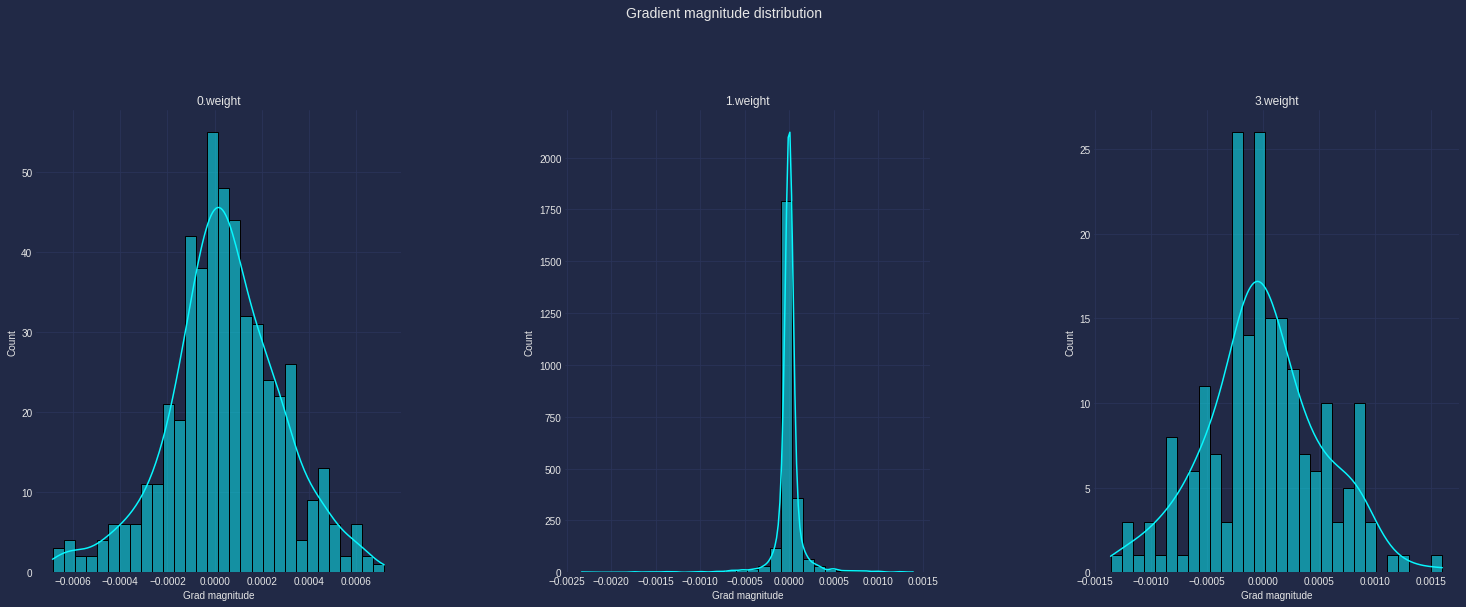

In [ ]:
grads = {name: params.grad.data.view(-1).clone().numpy()
         for name, params in model.named_parameters()
         if "weight" in name}
# Plotting
color="C0"
columns = len(grads)
fig, ax = plt.subplots(1, columns, figsize=(columns * 8.5, 8.5))
fig_index = 0
for key in grads:
    key_ax = ax[fig_index % columns]
    sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
    key_ax.set_title(str(key))
    key_ax.set_xlabel("Grad magnitude")
    fig_index += 1
fig.suptitle(
    "Gradient magnitude distribution",
    fontsize=14, y=1.05)
fig.subplots_adjust(wspace=0.45)
plt.show()

OrderedDict([('0.weight',
              tensor([[-0.8873, -0.7598, -0.5395,  0.3363,  0.8644, -0.8144,  0.4167,  0.2676,
                       -0.2501, -0.7625],
                      [-0.2615,  1.1428, -0.3051,  0.2539, -1.5375, -0.2325,  0.6569, -1.2578,
                       -1.0124, -0.6312],
                      [-1.0963, -0.3108, -1.1028, -0.3593, -0.9839, -0.0103,  1.2113,  0.3423,
                       -0.8575, -0.9451],
                      [ 1.1700,  0.2604, -0.8866,  1.2129, -0.3495, -0.2631, -1.1626, -0.5842,
                       -0.3009,  1.1259],
                      [ 1.0666,  0.7672, -0.2228, -1.4403, -0.6929, -1.0576,  0.6120, -0.3722,
                        0.1846,  0.1942],
                      [ 0.5874,  0.8380,  0.7130, -0.8360,  1.3254,  0.1495,  0.9431,  1.3517,
                       -0.5057,  0.1542],
                      [-0.1642,  0.8967, -0.6672,  0.7864, -1.0471,  0.3892, -1.4234,  0.6153,
                       -0.7046, -0.5053],
               